In [3]:
# Import libraries

from astropy.io import ascii
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table
from funcs import *
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import datetime as dt

%load_ext autoreload
%autoreload 2

In [4]:
# Set up times and locations

valid_dates = False
valid_times = False

default = False

print('--- DEFAULT PARAMETERS ---')
print('Observe from 20:00 UTC Tuesday to 03:59 UTC Wednesday')
print('First observe a test pulsar for 30 minutes')
print('Observe exoplanets for 80 minutes each for the rest of the time')

while default == False:

    lof = input('Use default parameters? [Y/N]').upper()

    if lof == 'Y':
        default = True

        # Find the dates of the next Tuesday (including possibly today) and Wednesday
        next_Tuesday_days = (1 - dt.datetime.today().weekday()) % 7
        next_Tuesday = dt.datetime.today() + dt.timedelta(days=next_Tuesday_days)
        next_Wednesday = dt.datetime.today() + dt.timedelta(days=next_Tuesday_days + 1)

        starting = next_Tuesday.strftime('%Y-%m-%d') + ' 20:00'
        ending = next_Wednesday.strftime('%Y-%m-%d') + ' 03:59'

    elif lof == 'N':
        break
    else:
        print(lof)
        print('Please only type "Y" or "N"')

# If making manual observations
if default == False:
    # Check that dates and times are in the right order
    while valid_dates == False:
        start_date = check_date('Please enter starting date of observation (YYYY-MM-DD): ')
        end_date = check_date('Please enter ending date of observation (YYYY-MM-DD): ')

        if (int(start_date[0:4]) > int(end_date[0:4])) or (int(start_date[0:4]) == int(end_date[0:4]) and int(start_date[5:7]) > int(end_date[5:7])) or (start_date[0:4] == end_date[0:4] and start_date[5:7] == end_date[5:7] and int(start_date[8:10]) > int(end_date[8:10])):
            print('End date must be the same or later than the start date')
        else:
            valid_dates = True

    while valid_times == False:
        start_time = check_time('Please enter starting time of observation (HH:MM): ')
        end_time = check_time('Please enter ending time of observation (HH:MM): ')

        if start_date == end_date:
            if (start_time == end_time) or (int(start_time[0:2]) > int(end_time[0:2])) or (int(start_time[0:2]) == int(end_time[0:2]) and int(start_time[3:5]) > int(end_time[3:5])):
                print('End time must be later than the start time')
            else:
                valid_times = True
        else:
            valid_times = True


    starting = start_date + ' ' + start_time
    ending = end_date + ' ' + end_time

starting_time = Time(starting, scale='utc')
ending_time = Time(ending, scale='utc')

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)


# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon) / 2
mid_lat = (birr_loc.lat + onsala_loc.lat) / 2
mid_loc = EarthLocation(lat=mid_lat, lon=mid_lon)
LST_start_mid = get_lst(mid_loc, starting)
LST_end_mid = get_lst(mid_loc, ending)

print('Starting LST at midpoint:', LST_start_mid)
get_lst(birr_loc, starting, 'Birr')
get_lst(onsala_loc, starting, 'Onsala')

print('\n')

print('Ending LST at midpoint:', LST_end_mid)
get_lst(birr_loc, ending, 'Birr')
get_lst(onsala_loc, ending, 'Onsala')

--- DEFAULT PARAMETERS ---
Observe from 20:00 UTC Tuesday to 03:59 UTC Wednesday
First observe a test pulsar for 30 minutes
Observe exoplanets for 80 minutes each for the rest of the time
Starting LST at midpoint: 15h21m00.23833434s
The local siderial time at Birr at UTC: 2024-07-09 20:00 is: 14h41m17.99833434s
The local siderial time at Onsala at UTC: 2024-07-09 20:00 is: 16h00m42.47833433s


Ending LST at midpoint: 23h21m18.92605372s
The local siderial time at Birr at UTC: 2024-07-10 03:59 is: 22h41m36.68605373s
The local siderial time at Onsala at UTC: 2024-07-10 03:59 is: 0h01m01.16605371s


In [5]:
# Import data and clean it up

# Check what objects are to be observed

if default == True:
    want_exo = True
    want_psr = False
else:
    want_exo = want('exoplanets')
    want_psr = want('pulsars independently')



# Pulsar data
# Need to at least observe a pulsar once for calibration purposes
pulsars = check_file('Path to CSV file containing pulsar names, coordinates and luminosities in ATNF format: ', ['NAME', 'RAJ', 'DECJ', 'R_LUM'])

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# The coordinates of the pulsars
psr_ra = np.array(pulsars['RAJ'])
psr_dec = np.array(pulsars['DECJ'])

psr_coords = SkyCoord(ra=psr_ra, dec=psr_dec, unit=(u.hourangle, u.deg))

In [6]:
# Pointing times

if default == True:
    pointing_time_psr_cal = 0.5 + 1/60
    pointing_time_planet = 4/3 + 1/60
else:
    pointing_time_psr_cal = check_time('Time to spend observing a calibration pulsar (HH:MM): ')
    pointing_time_psr_cal = (int(pointing_time_psr_cal[0:2])*u.hr + int(pointing_time_psr_cal[3:5])*u.min + 1*u.min).to(u.hr).value

    if want_exo == True:
        # How long we'll point at a planet
        pointing_time_planet = check_time('Time to spend observing a planet (HH:MM): ')
        pointing_time_planet = (int(pointing_time_planet[0:2])*u.hr + int(pointing_time_planet[3:5])*u.min + 1*u.min).to(u.hr).value

    if want_psr == True:
        # How long we'll point at a planet
        pointing_time_psr = check_time('Time to spend observing a pulsar (HH:MM): ')
        pointing_time_psr = (int(pointing_time_psr[0:2])*u.hr + int(pointing_time_psr[3:5])*u.min + 1*u.min).to(u.hr).value

# Copy of pulsars that we can delete stuff from
pulsars_copy = Table(pulsars, copy=True)

psr_coords_copy = SkyCoord(ra=np.array(pulsars_copy['RAJ']), dec=np.array(pulsars_copy['DECJ']), unit=(u.hourangle, u.deg))

# List of targets to ignore (uusally because they had been observed previously)
try:
    ignore = ascii.read('observed.csv')
    ignore.remove_column('date')
except:
    ignore = Table()

In [7]:

# Make the empty table of planets
if want_exo == True:
    planets = Table(names=['hostname', 'ra', 'dec', 'sy_dist'], dtype=[str, float, float, float])

# Optimise for closest to zenith at the middle of the observation window

time_LST = LST_start_mid.value
time_offset = 0
target_list = []
target_type = []

# How long from the start we will observe for
obs_time = (ending_time.mjd - starting_time.mjd) * 24 # hours

################################
# Calibration pulsar initially #
################################
mid_lst = (time_LST + pointing_time_psr_cal/2) * 15
zenith = SkyCoord(ra=mid_lst, dec=mid_lat, unit='deg')

sep = zenith.separation(psr_coords_copy)
ind = np.argmin(sep)
target_list.append(pulsars_copy['NAME'][ind])

# Delete that index from the coordinates array and the copy table to prevent repeats
psr_coords_copy = np.delete(psr_coords_copy, ind)
pulsars_copy.remove_row(ind)

target_type.append('pulsar')

time_offset += pointing_time_psr_cal
time_LST += pointing_time_psr_cal

#########################
# Go for obs_time hours #
#########################
while time_offset <= obs_time:
    # Find the RA that is directly overhead in the middle of the observation window
    # Find target that is closest to the zenith at the middle of the observation window

    # Exoplanets
    if want_exo == True:
        
        # Query for list of planets to target near the zenith
        potential_targets = NasaExoplanetArchive.query_region(table='pscomppars', coordinates=SkyCoord(ra=time_LST*u.hourangle, dec=mid_lat), radius=20*u.deg)
        potential_targets.keep_columns(('hostname', 'disc_facility', 'ra', 'dec', 'sy_dist'))

        # Only keep TESS targets
        ind = potential_targets['disc_facility'] == 'Transiting Exoplanet Survey Satellite (TESS)'
        potential_targets = potential_targets[ind]

        # Delete the specified targets to be ignored
        for i in range(len(ignore)):
            ind = potential_targets['hostname'] != ignore['name'][i]
            potential_targets = potential_targets[ind]
        
        # Make sure same target is not observed multiple times
        for i in range(len(target_list)):
            ind = potential_targets['hostname'] != target_list[i]
            potential_targets = potential_targets[ind]

        # The coordinates of the planets
        planets_ra = np.array(potential_targets['ra'])
        planets_dec = np.array(potential_targets['dec'])

        planets_coords = SkyCoord(ra=planets_ra, dec=planets_dec, unit='deg')

        mid_lst_planet = (time_LST + pointing_time_planet/2) * 15
        zenith_planet = SkyCoord(ra=mid_lst_planet, dec=mid_lat, unit='deg')
        sep_exo = zenith_planet.separation(planets_coords)
        ind_exo = np.argmin(sep_exo)
        sep_exo = sep_exo[ind_exo]
    else:
        sep_exo = np.inf

    # Pulsars
    if want_psr == True:
        mid_lst_psr = (time_LST + pointing_time_psr/2) * 15
        zenith_psr = SkyCoord(ra=mid_lst_psr, dec=mid_lat, unit='deg')
        sep_psr = zenith_psr.separation(psr_coords_copy)
        ind_psr = np.argmin(sep_psr)
        sep_psr = sep_psr[ind_psr]
    else:
        sep_psr = np.inf

    # See which is closest to zenith
    if sep_exo < sep_psr:
        target_list.append(potential_targets['hostname'][ind_exo])
        target_type.append('planet')

        planets.add_row((potential_targets['hostname'][ind_exo], potential_targets['ra'][ind_exo], potential_targets['dec'][ind_exo], potential_targets['sy_dist'][ind_exo]))
        
        # Move on
        time_offset += pointing_time_planet
        time_LST += pointing_time_planet
    else:
        target_list.append(pulsars_copy['NAME'][ind_psr])

        # Delete that index from the coordinates array and the copy table to prevent repeats
        psr_coords_copy = np.delete(psr_coords_copy, ind_psr)
        pulsars_copy.remove_row(ind_psr)

        target_type.append('pulsar')
        
        # Move on
        time_offset += pointing_time_psr
        time_LST += pointing_time_psr

# Output target list
print(target_list)

c:\Users\tcd\AppData\Local\Programs\Python\Python312\Lib\site-packages\astropy\table\table.py:3217: UserWarning: Units from inserted quantities will be ignored.
  self.insert_row(len(self), vals, mask)


['B1508+55', 'TOI-2260', 'TOI-2180', 'TOI-2010', 'TIC 365102760', 'TOI-1386', 'TOI-2285']


Text(0.5, 1.0, 'Optimum observation windows with distance against RA of the exoplanets plotted')

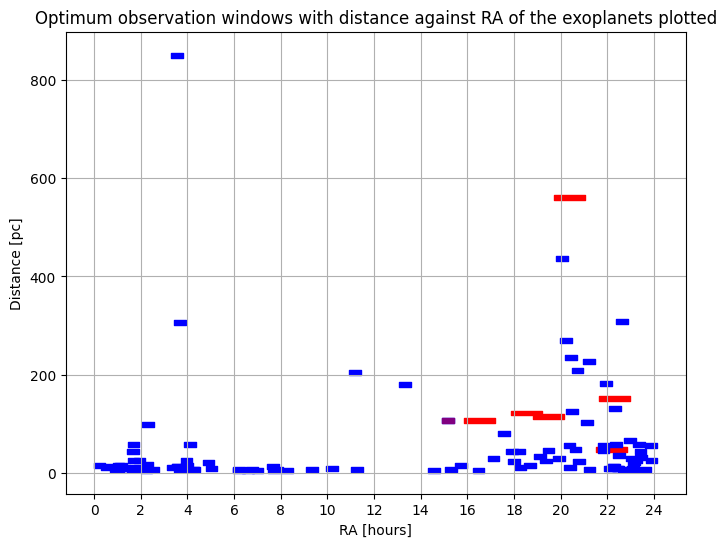

In [13]:
# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))

# Targeted planets in a different colour
for i in range(len(planets)):
    # Plot from optimum start time of observation
    ax.broken_barh([(planets['ra'][i] - (pointing_time_planet - 1/60) * 7.5, (pointing_time_planet - 1/60) * 15)], (planets['sy_dist'][i], 10), color='red')
    #ax.text(planets['ra'][ind]+0.5 - 10, planets['sy_dist'][ind], planets['hostname'][ind])

# All pulsars
for i in range(len(pulsars['NAME'])):
    # Plot from optimum start time of observation
    try:
        ax.broken_barh([(Angle(psr_ra[i], u.hourangle).value * 15 - (pointing_time_psr - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][i]/5, 10), color='green')
    except:
        ax.broken_barh([(Angle(psr_ra[i], u.hourangle).value * 15 - (pointing_time_psr_cal - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][i]/5, 10), color='green')

# Calibration pulsar in a different colour
index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

# Plot from optimum start time of observation
ax.broken_barh([(Angle(psr_ra[ind], u.hourangle).value * 15 - (pointing_time_psr_cal - 1/60) * 7.5, (pointing_time_psr_cal - 1/60) * 15)], (pulsars['R_LUM'][ind]/5, 10), color='purple')
        

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimum observation windows with distance against RA of the exoplanets plotted')


Text(0.5, 1.0, 'Scheduled time, LST against Distance of stars, blue dots - when the star reaches its zenith')

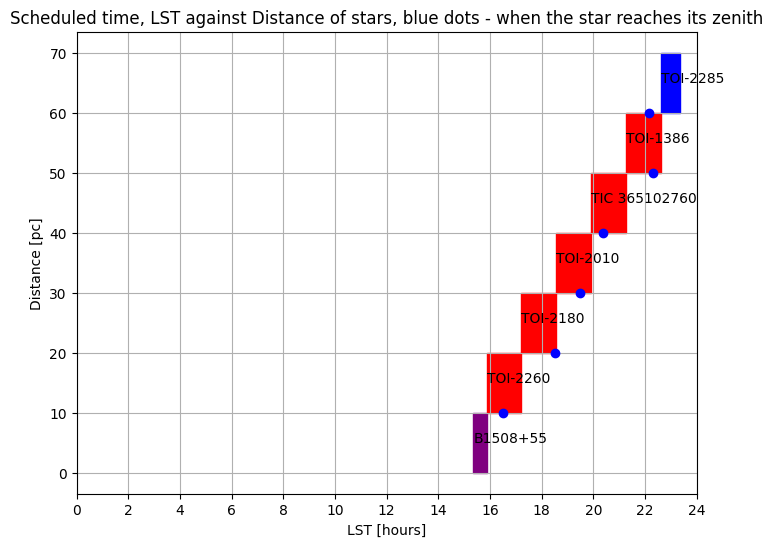

In [9]:
# Plot Actual viewing times
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

current_LST = LST_start_mid.value * 360/24
end_LST = LST_end_mid.value * 360/24

# Calibration pulsar in a different colour
index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

ax.broken_barh([(current_LST, pointing_time_psr_cal * 15)], (0, 10), color='purple')
ax.text(current_LST, 5, pulsars['NAME'][ind])

current_LST += pointing_time_psr_cal * 15

for i in range(len(planets)-1):
    # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + offset from ]
    ax.broken_barh([(current_LST, (pointing_time_planet * 15))], ((i+1)*10, 10), color='red')
    ax.text((current_LST) % 360, (i+1)*10+5, planets['hostname'][i])
    ax.plot(planets['ra'][i], (i+1)*10, 'bo')

    current_LST += pointing_time_planet * 15
    current_LST %= 360

ax.broken_barh([(current_LST, end_LST - current_LST)], ((i+2)*10, 10), color='blue')
ax.text((current_LST) % 360, (i+2)*10+5, planets['hostname'][-1])
ax.plot(planets['ra'][-1], (i+2)*10, 'bo')

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('LST [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Scheduled time, LST against Distance of stars, blue dots - when the star reaches its zenith')



In [10]:
# Output schedule with pointings and timings in iLiSA format

# Take same frequency range for all observations

freq_range = '100e6:190e6'

sched_iLiSA = Table(names=('Name', 'Time', 'RA', 'DEC', 'freqrng', 'dur'), dtype=(str, str, float, float, str, str))

time = starting_time.mjd

index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

sched_iLiSA.add_row((pulsars['NAME'][0], Time(time, format='mjd').iso[11:16], psr_coords[ind].ra.value*u.deg.to(u.rad), psr_coords[ind].dec.value*u.deg.to(u.rad), freq_range, str(int(np.round((pointing_time_psr_cal - 1/60) * 60))) + 'm'))

time += pointing_time_psr_cal/24

for i in range(1, len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    if i == len(target_list) - 1:
        dur = np.round((ending_time.mjd - time)*u.day.to(u.min))
        sched_iLiSA.add_row((planets['hostname'][ind], Time(time, format='mjd').iso[11:16], planets['ra'][ind]*u.deg.to(u.rad), planets['dec'][ind]*u.deg.to(u.rad), freq_range, str(dur) + 'm'))
    else:
        sched_iLiSA.add_row((planets['hostname'][ind], Time(time, format='mjd').iso[11:16], planets['ra'][ind]*u.deg.to(u.rad), planets['dec'][ind]*u.deg.to(u.rad), freq_range, str(int(np.round((pointing_time_planet - 1/60) * 60))) + 'm'))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24

In [11]:
# Output schedule with pointings and timings in I-LOFAR format

sched_realta = Table(names=('start', '-', 'stop', ':', 'name', 'coords'), dtype=(str, str, str, str, str, str))

time = starting_time.mjd

end_time = time + (pointing_time_psr_cal - 1/60)/24

index = pulsars['NAME'] == target_list[0]
ind = np.argwhere(index)[0][0]

sched_realta.add_row((Time(time, format='mjd').iso, '-', Time(end_time, format='mjd').iso, ':', pulsars['NAME'][ind], f'[{psr_coords[ind].ra.value*u.deg.to(u.rad)}, {psr_coords[ind].dec.value*u.deg.to(u.rad)}, \'J2000\']'))

time += pointing_time_psr_cal/24

for i in range(1, len(target_list)):
    index = planets['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    end_time = time + (pointing_time_planet - 1/60)/24
    # Make sure the end tiem doesn't overshoot
    if end_time > ending_time.mjd:
        end_time = ending_time.mjd

    sched_realta.add_row((Time(time, format='mjd').iso, '-', Time(end_time, format='mjd').iso, ':', planets['hostname'][ind], f'[{planets[ind][1]*u.deg.to(u.rad)}, {planets[ind][2]*u.deg.to(u.rad)}, \'J2000\']'))

    # Wait the 1 hr 21 minutes
    time += pointing_time_planet/24     


In [12]:
# Output files

ascii.write(sched_iLiSA, 'sched_iLiSA_temp.txt', overwrite=True)
ascii.write(sched_realta, 'sched_realta_temp.txt', overwrite=True)

# Need to remove the quotation marks
iLiSA = open('sched_iLiSA_temp.txt', 'r')
iLiSA_out = open('sched_iLiSA_out.txt', 'w')

rmv_quotes = iLiSA.read()
rmv_quotes = rmv_quotes.replace('"', '')

iLiSA_out.write(rmv_quotes)

realta = open('sched_realta_temp.txt', 'r')
realta_out = open('sched_realta_out.txt', 'w')

rmv_quotes = realta.read()
rmv_quotes = rmv_quotes.replace('"', '')

realta_out.write(rmv_quotes)

# Close the files
iLiSA.close()
iLiSA_out.close()

realta.close()
realta_out.close()